In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import moleculetools as mt
import seaborn as sns
import plot_utils as pu
import re

%matplotlib inline

pu.set_styles()

In [12]:
class System:
    def __init__(self, *args, **kwargs):
        self.name = kwargs.get('name', "system")
        self.ints = {}
        print("System instantiated!\n")
        
    def get_wn(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.wn = []
        for i in range(len(lines)):
            line = lines[i]
            if "Frequencies --" in line:
                self.wn += [float(x) for x in line.split()[2:]]
            else:
                pass
        
    def load_raman(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.ints['SL'] = []
        for i in range(len(lines)):
            line = lines[i]
            if "Raman Activ --" in line:
                self.ints['SL'] += [float(x) for x in line.split()[3:]]
            else:
                pass
    
    def load_uv(self, filename):
        with open(filename, 'r') as openfile:
            full = openfile.read()
            lines = openfile.readlines()
        
        nstates = re.search(r'(?<=nstates\=)\d+', full).group(0)
        states = re.findall(r'(?<=Excited State).*(?=\<\S\*\*2\>)', full)
        self.uv_data = {}
        for state in states:
            state_n = int(state.split()[0].split(':')[0])
            nm = float(state.split()[4])
            f = float(state.split()[6].split('=')[-1])
            self.uv_data[state_n] = {}
            self.uv_data[state_n]['nm'] = nm
            self.uv_data[state_n]['f'] = f
            
    def load_rr(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        tmp = []
        for i in range(len(lines)):
            line = lines[i]
            if "RamAct Fr= 1--" in line:
                tmp += [float(x) for x in line.split("--")[1].split()]
            elif "Using perturbation frequencies:" in line:
                in_wl = round(45.56335/float(line.split(':')[1]))
            else:
                pass
        self.ints["{}nm".format(in_wl)] = tmp
        
    def load_intmodes(self, filename, mol_atoms):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        rawmodes = []
        reading_mode = False
        for i in range(len(lines)):
            line = lines[i]
            if "Normal Mode" in line:
                reading_mode = True
                mode_start = i
            elif "-"*80 in line and reading_mode and i - mode_start > 3:
                mode_end = i
                rawmodes.append(lines[mode_start+4:mode_end])
                reading_mode = False
            else:
                pass

        self.intmodes = {'mol%':[], 'mix%':[], 'sur%':[]}
        for mode in rawmodes:
            mol, mix, sur = (0, 0, 0)
            for vib in mode:
                vib_parts = vib.split()
                desc = vib_parts[2]
                atom_substring = desc[desc.find('(')+1:desc.find(')')]
                atoms = [int(x) for x in atom_substring.split(',')]
                value = float(vib_parts[3])

                if all(i in mol_atoms for i in atoms):
                    mol += abs(value)
                elif any(i in mol_atoms for i in atoms):
                    mix += abs(value)
                else:
                    sur += abs(value)

            total = (mol + mix + sur)/100
            wmol, wmix, wsur = np.array([mol, mix, sur])/total
            self.intmodes['mol%'].append(wmol)
            self.intmodes['mix%'].append(wmix)
            self.intmodes['sur%'].append(wsur)

            
def make_df(system):
    df = pd.concat([pd.DataFrame(data=np.arange(1, len(system.wn) + 1), columns=['mode']),
                    pd.DataFrame(data=system.wn, columns=['wn']),
                    pd.DataFrame(data=system.intmodes),
                    pd.DataFrame(data=system.ints)],
                   axis=1)
    df.set_index('mode', inplace=True)
    try:
        nm_cols = [col for col in df.columns if "nm" in col]
        other_cols = [col for col in df.columns if col not in nm_cols]
        new_col_list = other_cols + sorted(nm_cols, key=lambda x:x[:3])
        df = df[new_col_list]
        nm_cols = [col for col in df.columns if "nm" in col]
        for col in nm_cols:
            df['{} ef'.format(col)] = np.log10(df[col]/df['SL'])
        ef_cols = [col for col in df.columns if "ef" in col]
        other_cols = [col for col in df.columns if col not in ef_cols]
        new_col_list = other_cols + sorted(ef_cols, key=lambda x:x[:3])
        df = df[new_col_list]
    except:
        print('Error! Check make_df()')
    print(df.head())
    print(df.info())
    return df

def plot_raman(system=None, modes=None, xlim='auto', mode='SL', rr_list=None):
    f, ax = pu.new_figure(height=5, type='body')
    
    margin = (max(system.wn) - min(system.wn))*0.05
    if xlim == 'auto':
        xmin = np.where(min(system.wn) - margin >= 0, min(system.wn) - margin, 0)
        xmin = np.floor(xmin/100)*100
        xmax = np.where(max(system.wn) + margin >= 0, max(system.wn) + margin, 0)
        xmax = np.ceil(xmax/100)*100
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')

    raman_preexp = 1
    raman_sigma = 4
    
    if mode == 'SL':
        points, gaussians = calculate_envelope(x=system.wn, y=system.ints['SL'],
                                               preexp=raman_preexp, sigma=raman_sigma)
        sns.lineplot(points, gaussians.sum(axis=0), ax=ax, color=pu.colors['color1'])
        
    elif mode == 'multirr':
        if rr_list is not None:
            for rr in rr_list:
                points, gaussians = calculate_envelope(x=system.wn, y=system.ints['{}nm'.format(rr)],
                                                       preexp=raman_preexp, sigma=raman_sigma)
                sns.lineplot(points, gaussians.sum(axis=0), ax=ax, color=pu.colors['color1'])
        else:
            pass

    if modes is not None:
        for mode in modes:
            ax.axvline(x=system.wn[mode - 1], ymin=0, ymax=1)
            ax.text(x=system.wn[mode - 1] + ax.get_xlim()[1]*0.005, y=ax.get_ylim()[1]*0.95, s=str(mode))

    pu.tuftefy(ax)
    return f, ax    


def plot_uv(system=None, xlim='auto', main_color=pu.colors['color1'], linestyle='-', states_to_plot=None, height=5, f=None, ax=None, label=None):
    if f == None and ax == None:
        f, ax = pu.new_figure(height=height, type='body')

    all_nm = [system.uv_data[state]['nm'] for state in system.uv_data.keys()]
    all_f = [system.uv_data[state]['f'] for state in system.uv_data.keys()]

    margin = (max(all_nm) - min(all_nm))*0.05
    if xlim == 'auto':
        xmin = np.where(min(all_nm) - margin >= 0, min(all_nm) - margin, 0)
        xmin = np.floor(xmin/50)*50
        xmax = np.where(max(all_nm) + margin >= 0, max(all_nm) + margin, 0)
        xmax = np.ceil(xmax/50)*50
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\lambda$ (nm)')
    ax.set_ylabel(r'$\varepsilon$ (L mol$^{-1}$ cm$^{-1}$)')

    uv_preexp = 40489.9942104
    uv_sigma = 0.000322622
    all_nm = [1/nm for nm in all_nm]
    points, gaussians = calculate_envelope(x=all_nm,
                                           y=all_f,
                                           preexp=uv_preexp,
                                           sigma=uv_sigma,
                                           xrange=xlim,
                                           inverse=True)

    if states_to_plot != None:
        
        if type(states_to_plot) == list:
            pass

        elif type(states_to_plot) == int:
            f_values = np.array(all_f)
            state_and_f = list(zip(range(1, len(f_values) + 1), f_values))
            sorted_state_and_f = sorted(state_and_f, key=lambda x:x[1], reverse=True)
            print(sorted_state_and_f)
            states_to_plot = [sf[0] for sf in sorted_state_and_f[:states_to_plot]]
            #states_to_plot = f_values.argsort()[-states_to_plot:][::-1]
            #states_to_plot = [s + 1 for s in states_to_plot]
            
        print(states_to_plot)
        
        for i, state in enumerate(states_to_plot):
            color_list = list(pu.colors.values())[1:]
            #sns.lineplot(points, gaussians[state - 1], linestyle='--', ax=ax)
            ax.plot(points, gaussians[state - 1], linestyle='--', color=color_list[i])
            ax.text(x = system.uv_data[state]['nm'],
                    y = max(gaussians[state - 1]) + max(gaussians.sum(axis=0))*0.02,
                    s = "{} nm".format(system.uv_data[state]['nm']),
                    ha = 'center', color=color_list[i])
            
    
    #sns.lineplot(points, gaussians.sum(axis=0), ax=ax, color=main_color, linestyle=linestyle)
    ax.plot(points, gaussians.sum(axis=0), color=main_color, linestyle=linestyle)#, label=label)
    pu.tuftefy(ax)
    return f, ax


def calculate_envelope(x, y, npoints=10000, preexp=1, sigma=1, xrange=[0, 4000], inverse=False):
    xspace = np.linspace(xrange[0], xrange[1], npoints)
    points = xspace
    if inverse == True:
        points = points**(-1)
    gaussians = []
    for pair in list(zip(x, y)):
        gaussians.append(pair[1]*preexp*np.exp(-np.square((points - pair[0])/sigma)))
    return xspace, np.array(gaussians)

def load_flower(nameid):
    system = System(name=nameid)
    system.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    return system

def load_complex(nameid):
    system = System(name=nameid)
    natoms = int(nameid[-2:])*3
    print('Number of atoms: {}'.format(natoms))
    system.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/{}/uv-{}stx.out'.format(nameid, nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_intmodes('/Users/oscar/Dropbox/s3/flowers-and-stx/single-intmodes/intmodes_{}stx.log'.format(nameid),
    mol_atoms = list(range(1, natoms + 1)))
    import glob
    path = '/Users/oscar/CALC/STX/sunflowers/flower-garden/rr/{}/*_FIX.log'.format(nameid)
    for rr in glob.glob(path):
        system.load_rr(rr)
    return system

No handles with labels found to put in legend.


System instantiated!

[24, 30]


No handles with labels found to put in legend.


(<Figure size 774x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ad1c748>)

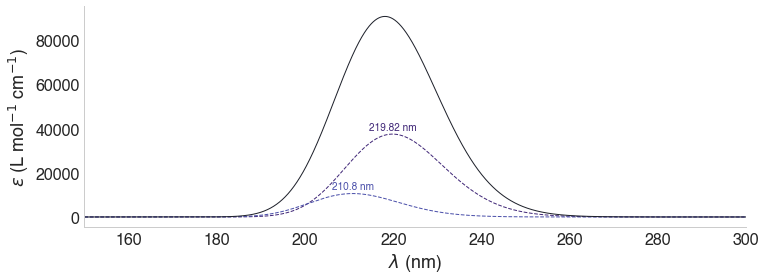

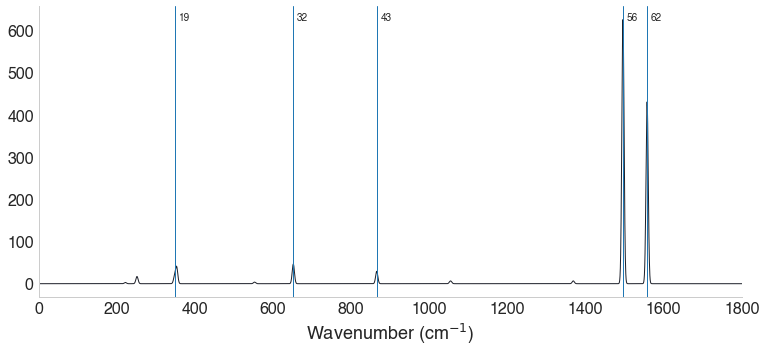

In [10]:
sys = load_flower('s08')
plot_uv(system=sys, states_to_plot=[24, 30], height=4)
plot_raman(system=sys, modes=[19, 32, 43, 56, 62])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!

System instantiated!



No handles with labels found to put in legend.


(<Figure size 774x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b0a9898>)

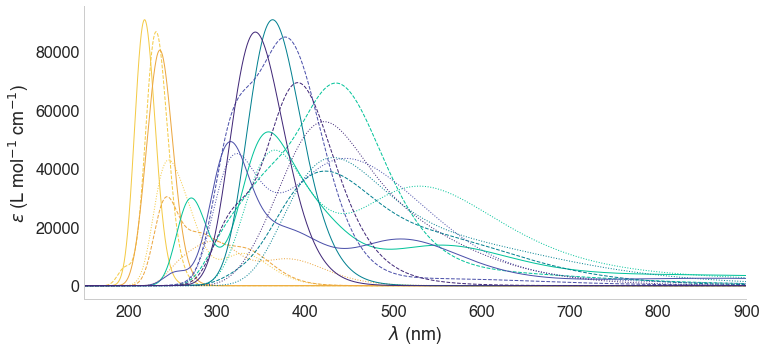

In [13]:
def plot_uv_list(sys_list, petal_list):
    uv_list = [a + b for a in sys_list for b in petal_list]
    f = None
    ax = None
    for sys in sys_list:
        for petals in petal_list:
            name = sys + petals
            com = System(name=name)
            #com.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/{}/uv-{}stx.out'.format(name, name))
            com.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(name))
            f, ax = plot_uv(com, f=f, ax=ax, main_color=pu.sys_colors[sys], xlim=[150, 900], linestyle=pu.petal_styles[petals], label=name)
    return f, ax

sys_list = ['s', 'se', 'as', 'asn', 'p', 'pn']
petal_list = ['08', '10', '12']

plot_uv_list(sys_list, petal_list)

System instantiated!

Number of atoms: 30
System instantiated!

Number of atoms: 36


No handles with labels found to put in legend.
No handles with labels found to put in legend.


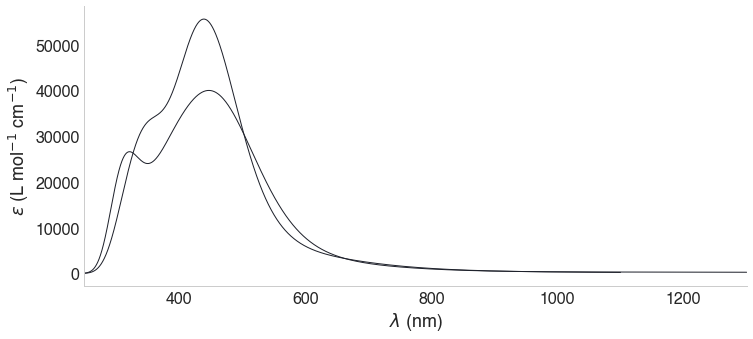

In [247]:
com1 = load_complex('as10')
com2 = load_complex('p12')
f, ax = plot_uv(com1)
f, ax = plot_uv(com2, f=f, ax=ax)

In [175]:
com = load_complex('as10')

System instantiated!

Number of atoms: 30


cool_modes
 [105, 137, 149, 150, 155, 156, 158, 170, 173, 176, 177, 190]
cool_nm
 [300, 324, 345, 354, 357, 375, 381, 429, 432, 435, 438, 450, 453, 456, 498, 594, 597, 600]
0.0 101.0


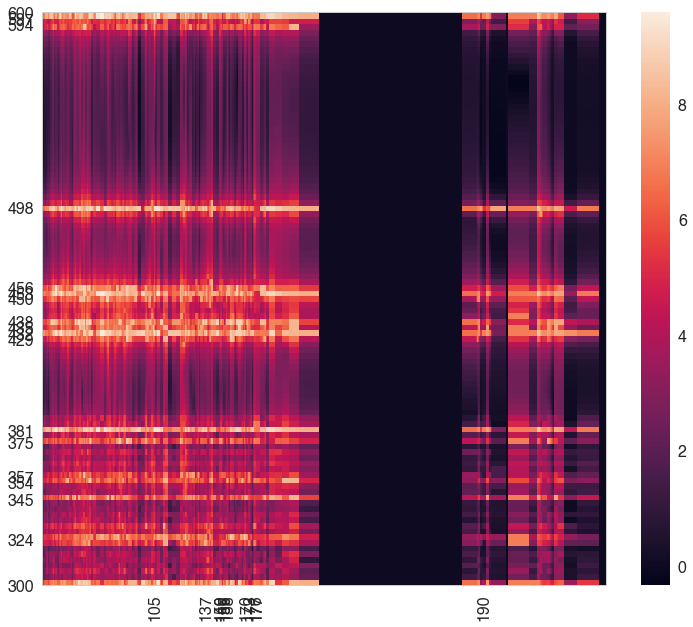

In [239]:
def make_df(system):
    df = pd.concat([pd.DataFrame(data=np.arange(1, len(system.wn) + 1), columns=['mode']),
                    pd.DataFrame(data=system.wn, columns=['wn']),
                    pd.DataFrame(data=system.intmodes),
                    pd.DataFrame(data=system.ints)],
                   axis=1)
    df.set_index('mode', inplace=True)
    try:
        nm_cols = [col for col in df.columns if "nm" in col]
        other_cols = [col for col in df.columns if col not in nm_cols]
        new_col_list = other_cols + sorted(nm_cols, key=lambda x:x[:3])
        df = df[new_col_list]
        nm_cols = [col for col in df.columns if "nm" in col]
        for col in nm_cols:
            df['{} ef'.format(col)] = np.log10(df[col]/df['SL'])
        ef_cols = [col for col in df.columns if "ef" in col]
        other_cols = [col for col in df.columns if col not in ef_cols]
        new_col_list = other_cols + sorted(ef_cols, key=lambda x:x[:3])
        df = df[new_col_list]
    except:
        print('Error! Check make_df()')
    #print(df.head())
    #print(df.info())
    return df


def plot_hm(system, maxsur=75, minmol=25, minef=7, vmin=0, vmax=10, xrange=[0, 4000], cool_modes=None, cool_nm=None):
    nm_list = []
    spec_list = []
    sl_ints = system.ints['SL']
    points, sl_env = calculate_envelope(x=system.wn, y=sl_ints, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
    for k, v in sorted(system.ints.items(), key=lambda x:x[0][:3])[:-1]:
        nm_list.append(k)
        points, env = calculate_envelope(x=system.wn, y=v, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
        
        gaussians = env.sum(axis=0)
        gaussians = np.where(gaussians==0, 1, gaussians)
        
        sl_gaussians = sl_env.sum(axis=0)
        sl_gaussians = np.where(sl_gaussians==0, 1, sl_gaussians)
        
        div = gaussians/sl_gaussians
        spec_list.append(np.log10(div))
        
    f, ax = pu.new_figure(height=9, type='body')
    sns.heatmap(data=np.array(spec_list), ax=ax)
    
    df = make_df(system)
    if cool_modes == None:
        cool_modes = list(df[(df['sur%'] <= maxsur) & (df['mol%'] >= minmol)].index)
        print("cool_modes\n", cool_modes)
        
    if cool_nm == None:
        cool_nm = [col for col in df.columns if df[col].max() >= minef and "ef" in col]
        cool_nm = [int(nm[:3]) for nm in cool_nm]
        print("cool_nm\n", cool_nm)

    # Annotate modes
    xmin, xmax = ax.get_xlim()
    #cool_modes = [23, 50, 120]
    cool_mode_positions = []
    for mode in cool_modes:
        wn = system.wn[mode - 1]
        fraction = (wn - xrange[0])/(xrange[1] - xrange[0])
        position = fraction*(xmax - xmin)
        cool_mode_positions.append(position)
    ax.set_xticks(cool_mode_positions)
    ax.set_xticklabels(cool_modes)
    
    # Annotate wavelengths
    ax.set_ylim([0, len(nm_list)])
    nm_list = [int(nm[:3]) for nm in nm_list]
    ymin, ymax = ax.get_ylim()
    print(ymin, ymax)
    #cool_nm = [360, 372, 522]
    cool_nm_positions = []
    for nm in cool_nm:
        fraction = (nm - min(nm_list))/(max(nm_list) - min(nm_list))
        position = fraction*(ymax - ymin)
        cool_nm_positions.append(position)
    ax.set_yticks(cool_nm_positions)
    ax.set_yticklabels(cool_nm)
    
    # rotate y tick labels
    ax.tick_params(axis='y', rotation=0)
    
    # set spines as visible
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    #df = make_df(system)
    
    #f, ax = pu.new_figure(height=9, type='body')
    #df = df[(df['sur%'] <= maxsur) & (df['mol%'] >= minmol)]
    #df = df[[col for col in df.columns if 'ef' in col]]
    #df = df[[col for col in df.columns if df[col].max() >= minef]]
    #df.columns = [col[:3] for col in df.columns]
    #sns.heatmap(df, ax=ax, vmin=vmin, vmax=vmax,
    #            #cbar_kws={'label':'EF'},
    #            #cmap='twilight'
    #           )
    #ax.set_ylim([df.shape[0], 0])
    #ax.set_ylabel(r'Normal mode ID')
    #ax.set_xlabel(r'Incident laser $\lambda$ (nm)')
    #pu.tuftefy(ax)
    
plot_hm(com, xrange=[0, 4000], maxsur=70, minmol=30, minef=8.5, vmax=10)

[(21, 0.2019), (11, 0.1955), (23, 0.1518), (14, 0.0916), (20, 0.0907), (15, 0.082), (3, 0.0812), (37, 0.0752), (31, 0.0731), (2, 0.0576), (8, 0.0575), (12, 0.0574), (28, 0.0529), (13, 0.0482), (32, 0.0425), (38, 0.0423), (6, 0.0377), (1, 0.0353), (24, 0.0344), (30, 0.033), (33, 0.0321), (19, 0.0314), (22, 0.0223), (34, 0.0223), (29, 0.0204), (36, 0.0193), (26, 0.0183), (9, 0.0173), (5, 0.0166), (27, 0.0128), (39, 0.0125), (40, 0.0104), (25, 0.0099), (41, 0.0097), (35, 0.0093), (10, 0.0089), (17, 0.0067), (16, 0.0064), (43, 0.0058), (49, 0.0046), (50, 0.0042), (46, 0.0037), (47, 0.0033), (18, 0.0032), (45, 0.003), (42, 0.0025), (44, 0.0019), (7, 0.0016), (4, 0.0014), (48, 0.0005)]
[21, 11, 23, 14]


No handles with labels found to put in legend.


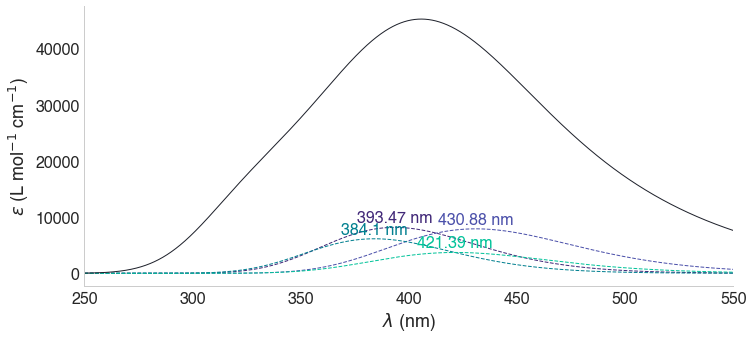

In [67]:
f, ax = plot_uv(system=com, states_to_plot=4)

In [304]:
def run_sim(start=0):
    points = np.arange(1, 1000, 1)
    charge_points = np.arange(1, 1000, 3)

    buffer = 0
    for point in points[:start]:
        if point in charge_points:
            buffer += 2
    for point in points[start:]:

        if point in charge_points:
            buffer += 1
        else:
            buffer -= 1

        if buffer <= 0 and (point + 1) not in charge_points:
            break
    return point - start

Text(0, 0.5, 'Available play time (T)')

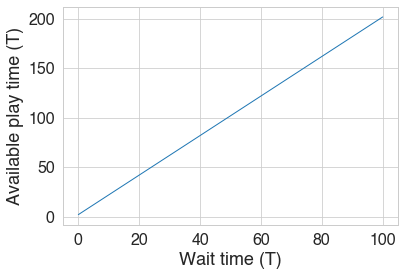

In [308]:
wait_times = np.arange(0, 101, 1)
play_times = [run_sim(start=t) for t in wait_times]
sns.lineplot(x=wait_times, y=play_times)
plt.xlabel('Wait time (T)')
plt.ylabel('Available play time (T)')

In [306]:
for i, t in enumerate(wait_times):
    print(t, play_times[i])

0 2
1 4
2 6
3 8
4 10
5 12
6 14
7 16
8 18
9 20
10 22
11 24
12 26
13 28
14 30
15 32
16 34
17 36
18 38
19 40
20 42
21 44
22 46
23 48
24 50
25 52
26 54
27 56
28 58
29 60
30 62
31 64
32 66
33 68
34 70
35 72
36 74
37 76
38 78
39 80
40 82
41 84
42 86
43 88
44 90
45 92
46 94
47 96
48 98
49 100
50 102
51 104
52 106
53 108
54 110
55 112
56 114
57 116
58 118
59 120
60 122
61 124
62 126
63 128
64 130
65 132
66 134
67 136
68 138
69 140
70 142
71 144
72 146
73 148
74 150
75 152
76 154
77 156
78 158
79 160
80 162
81 164
82 166
83 168
84 170
85 172
86 174
87 176
88 178
89 180
90 182
91 184
92 186
93 188
94 190
95 192
96 194
97 196
98 198
99 200
100 202
